## Finding and Hedging Portfolio Beta Using Linear Regression

In [1]:
%pip install statsmodels

Note: you may need to restart the kernel to use updated packages.


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
from IPython.display import Markdown, display
from openbb import obb
from statsmodels import regression

In [3]:
obb.user.preferences.output_type = "dataframe"

Define the stock symbols including the benchmark "SPY"

In [4]:
symbols = [
    "NEM",
    "RGLD",
    "SSRM",
    "CDE",
    "LLY",
    "UNH",
    "JNJ",
    "MRK",
    "SPY",
    "GOOG",
    "META"
]

Fetch historical price data for the defined symbols from 2020-01-01 to 2022-12-31 using the "yfinance" provider

In [5]:
data = obb.equity.price.historical(
    symbols,
    start_date="2020-01-01",
    end_date="2022-12-31",
    provider="yfinance",
).pivot(columns="symbol", values="close")

Calculate the daily percentage returns for the benchmark "SPY" and drop any missing values

In [6]:
benchmark_returns = data.pop("SPY").pct_change().dropna()

Calculate the daily percentage returns for the portfolio and drop any missing values

In [7]:
portfolio_returns = data.pct_change().dropna().sum(axis=1)
portfolio_returns.name = "portfolio"

Plot the portfolio and benchmark daily returns

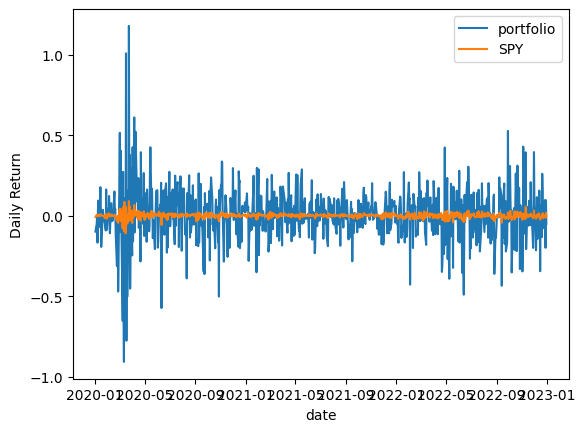

In [8]:
portfolio_returns.plot()
benchmark_returns.plot()
plt.ylabel("Daily Return")
plt.legend()
plt.show()

Define a function for linear regression to calculate alpha and beta

In [9]:
def linreg(x, y):
    # Add a column of 1s to fit alpha

    x = sm.add_constant(x)
    model = regression.linear_model.OLS(y, x).fit()
    # Remove the constant now that we're done

    x = x[:, 1]
    return model.params[0], model.params[1]

Perform linear regression on the portfolio and benchmark returns to calculate alpha and beta

In [10]:
X = benchmark_returns.values
Y = portfolio_returns.values

In [11]:
alpha, beta = linreg(X, Y)

In [12]:
display(f"Alpha: {alpha}")
display(f"Beta: {beta}")

'Alpha: 0.002160322364186733'

'Beta: 7.921394228106543'

Plot the regression line

In [13]:
X2 = np.linspace(X.min(), X.max(), 100)
Y_hat = X2 * beta + alpha

Plot the raw data

Text(0, 0.5, 'Portfolio daily return')

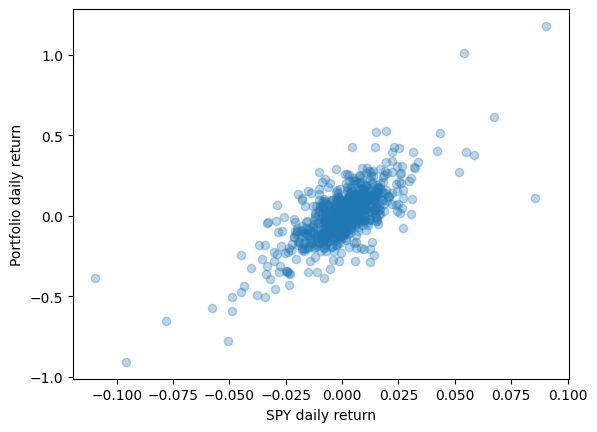

In [14]:
plt.scatter(X, Y, alpha=0.3)
plt.xlabel("SPY daily return")
plt.ylabel("Portfolio daily return")

Add the regression line

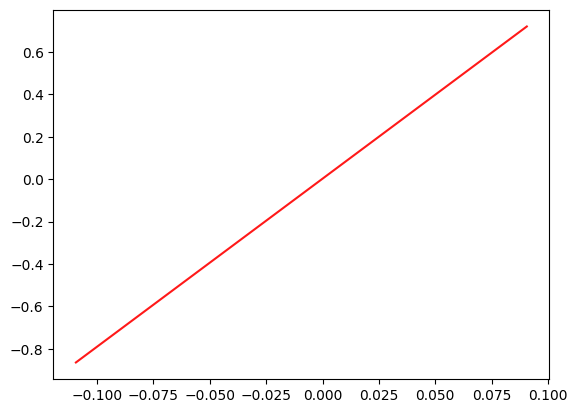

In [15]:
plt.plot(X2, Y_hat, "r", alpha=0.9)
plt.show()

Construct a portfolio with beta hedging

In [16]:
hedged_portfolio_returns = -1 * beta * benchmark_returns + portfolio_returns

Perform linear regression on the hedged portfolio returns and benchmark returns to calculate alpha and beta

In [17]:
P = hedged_portfolio_returns.values
alpha, beta = linreg(X, P)

In [18]:
display(f"Alpha: {alpha}")
display(f"Beta: {beta}")

'Alpha: 0.002160322364186736'

'Beta: -7.978864537800308e-15'

Define a function to calculate the information ratio

In [19]:
def information_ratio(portfolio_returns, benchmark_returns):
    """
    Determines the information ratio of a strategy.

    Parameters
    ----------
    portfolio_returns : pd.Series or np.ndarray
        Daily returns of the strategy, noncumulative.
    benchmark_returns : int, float
        Daily returns of the benchmark or factor, noncumulative.
    Returns
    -------
    information_ratio : float
    Note
    -----
    See https://pyquantnews.com/how-to-measure-skill-portfolio-manager/ for more details.
    """

    active_return = portfolio_returns - benchmark_returns
    tracking_error = active_return.std()
    return active_return.mean() / tracking_error

Calculate the information ratio for the hedged and unhedged portfolios

In [20]:
hedged_ir = information_ratio(hedged_portfolio_returns, benchmark_returns)

In [21]:
unhedged_ir = information_ratio(portfolio_returns, benchmark_returns)

In [22]:
display(f"Hedged information ratio: {hedged_ir}")
display(f"Unhedged information ratio: {unhedged_ir}")

'Hedged information ratio: 0.01567174111125199'

'Unhedged information ratio: 0.028510338851445778'

**Jason Strimpel** is the founder of <a href='https://pyquantnews.com/'>PyQuant News</a> and co-founder of <a href='https://www.tradeblotter.io/'>Trade Blotter</a>. His career in algorithmic trading spans 20+ years. He previously traded for a Chicago-based hedge fund, was a risk manager at JPMorgan, and managed production risk technology for an energy derivatives trading firm in London. In Singapore, he served as APAC CIO for an agricultural trading firm and built the data science team for a global metals trading firm. Jason holds degrees in Finance and Economics and a Master's in Quantitative Finance from the Illinois Institute of Technology. His career spans America, Europe, and Asia. He shares his expertise through the <a href='https://pyquantnews.com/subscribe-to-the-pyquant-newsletter/'>PyQuant Newsletter</a>, social media, and has taught over 1,000+ algorithmic trading with Python in his popular course **<a href='https://gettingstartedwithpythonforquantfinance.com/'>Getting Started With Python for Quant Finance</a>**. All code is for educational purposes only. Nothing provided here is financial advise. Use at your own risk.